In [1]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoModel,
    BitsAndBytesConfig,
    TrainingArguments,
    TextIteratorStreamer
)

/scratch/users/anup/miniconda3/envs/finetune-gllm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-03-26 16:53:34,389] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
import deepspeed
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer, AutoModel
import torch
from peft import AutoPeftModelForCausalLM, PeftModel

base_dir = "llama-linear-layers-all-conv-Feb-19-24-1"
#"llama-linear-layers-all-conv-Dec-08-02"
checkpoint_number = "checkpoint-2500"
checkpoint_path = "{}/{}".format(base_dir, checkpoint_number)
model_name = "NousResearch/Llama-2-7b-chat-hf"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype
)


original_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    use_cache=False,
    device_map="auto"
)

peft_model = PeftModel.from_pretrained(original_model, checkpoint_path)
#peft_model = peft_model.merge_and_unload()
#restored_tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModel.from_pretrained("your_username/my-awesome-model")

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]
/scratch/users/anup/miniconda3/envs/finetune-gllm/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/scratch/users/anup/miniconda3/envs/finetune-gllm/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was

In [3]:
#save model to HuggingFace hub

In [4]:
# https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/mixtral-8x7b-for-web-qa.ipynb

In [5]:
from getpass import getpass
HF_TOKEN = getpass("<<>>")

<<>> ········


In [6]:
import requests
import json
import os
import glob
import fnmatch
import pandas as pd
import markdown
from html import unescape
from bs4 import BeautifulSoup

In [7]:
#import haystack
from haystack import Document, Pipeline
#from haystack.nodes import PreProcessor
#from haystack.document_stores import InMemoryDocumentStore

from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.document_stores.in_memory import InMemoryDocumentStore

#from haystack.nodes import BM25Retriever, PromptNode, PromptTemplate
from haystack.components.builders.prompt_builder import PromptBuilder

In [8]:
# Collect from GTN

docs = []
directory_path = "../../../gtn-data/"

def read_md_file_1(path):
    with open(path) as f:
        content = f.read()
        return content

def read_md_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        md_content = file.read()
    return extract_plain_text_from_md(md_content)

def extract_plain_text_from_md(md_content):
    html_content = markdown.markdown(md_content)
    plain_text = ''.join(BeautifulSoup(html_content, "html.parser").findAll(text=True))
    return plain_text.strip()
    
#included_content = "/topics/statistics/tutorials/intro_deep_learning/"

included_content = "/topics/"

'''for root, dirs, files in os.walk(directory_path):
    for filename in files:
        if fnmatch.fnmatch(filename, '*.md'):
            path = os.path.join(root, filename)
            if included_content in path:
                s_path = path.split("/")[-3:]
                tutorial_name = "_".join(s_path)
                md_plain_text = read_md_file(path)
                #pr_dict = {"content": md_plain_text, "meta": {"name": tutorial_name}}
                doc = Document(content=md_plain_text)
                #doc = Document.from_json(json.dumps(pr_dict))
                docs.append(doc)'''


# Collect from PRs
import secrets

def generate_hex_id(length):
    # Generate a random byte string
    random_bytes = secrets.token_bytes(length // 2)  # Length is halved because 1 byte = 2 hex characters

    # Convert the byte string to a hexadecimal representation
    hex_id = random_bytes.hex()

    return hex_id

# process PRs
for json_file in glob.glob("../out/github_pr_page_*.json"):
    with open(json_file, "r") as fin:
        doc_json = json.load(fin)
        for pr in doc_json:
            pr_text = pr["body"]
            if pr_text != None:
                useful_text_limit = pr_text.find("## How to test the changes")
                if useful_text_limit > 0:
                    pr_text = pr_text[:useful_text_limit].strip()
                    #pr_dict = {"content": pr_text, "meta": {"name": pr["number"]}}
                    doc = Document(content=pr_text, id=generate_hex_id(10))
                    #doc = Document.from_json(json.dumps(pr_dict))
                    docs.append(doc)

In [9]:
'''processor = PreProcessor(
    clean_empty_lines=True,
    clean_whitespace=True,
    clean_header_footer=True,
    split_by="word",
    split_length=200,
    split_respect_sentence_boundary=True,
    split_overlap=0,
    language="en",
)'''

document_store = InMemoryDocumentStore()
retriever = InMemoryBM25Retriever(document_store=document_store, top_k=4)

pipeline = Pipeline()
pipeline.add_component(instance=retriever, name="retriever")
document_store.write_documents(docs)

#result = pipeline.run(data={"retriever": {"query": "How to make Galaxy pull request?"}})

#print(result["retriever"]["documents"])

#preprocessed_docs = processor.process(docs)
#document_store = InMemoryDocumentStore(use_bm25=True)
#document_store.write_documents(preprocessed_docs)
#retriever = BM25Retriever(document_store, top_k=4)

# a good Question Answering template, adapted for the instruction format
# (https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1)

3654

In [18]:
from haystack import component

@component
class FineTunedGenerator:
  """
  A component generating query response by fine-tuned LLM
  """
  @component.output_types(response=str)
  def run(self, query:str):
      print("Generating text...")
      restored_tokenizer = AutoTokenizer.from_pretrained(model_name)
      input_ids = restored_tokenizer.encode(query, return_tensors="pt").to('cuda')
      outputs = peft_model.generate(
          input_ids=input_ids, 
          max_new_tokens=256,
          do_sample=True,
      )
      print("Finished generation")
      return {"response": outputs}

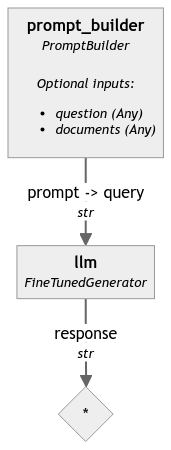

In [19]:
prompt_template = """
According to these documents:

{% for doc in documents %}
  {{ doc.content }}
{% endfor %}

Answer the given question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=prompt_template)

pipeline = Pipeline()
#pipeline.add_component("fetcher", fetcher)
#pipeline.add_component("converter", converter)
#pipeline.add_component("splitter", document_splitter)
#pipeline.add_component("ranker", similarity_ranker)
pipeline.add_component("prompt_builder", prompt_builder)
pipeline.add_component(name="llm", instance= FineTunedGenerator())
pipeline.connect("prompt_builder", "llm")

In [20]:
question = "How can I run a rna-seq analysis in Galaxy?"
result = pipeline.run({"prompt_builder": {"question": question}})

print(result['llm']['response'])

Generating text...
Finished generation
tensor([[    1, 29871,    13,  7504,  3278,   304,  1438, 10701, 29901,    13,
            13,    13,    13, 22550,   278,  2183,  1139, 29901,  1128,   508,
           306,  1065,   263,   364,  1056, 29899, 11762,  7418,   297,  5208,
         26825, 29973,    13, 22550, 29901,   364,  1056, 29899, 11762,   338,
           263,  1134,   310,   302,  3174,   848, 29889,   727,   526,  1784,
         25410,  1244,   363,   302,  3174,  7418, 29889,    13,    13,    13,
           991,   597, 23014, 26825,  4836, 29889,  3292, 29889,   601, 29914,
         26495, 29899, 15388, 29914,  3332,  1199, 29914,  3286,   924,   290,
          1199, 29914, 12631, 29879, 29914,   999, 29899,  6707, 29914, 12631,
         29889,  1420,    13,    13,   991,   597, 23014, 26825,  4836, 29889,
          3292, 29889,   601, 29914, 26495, 29899, 15388, 29914,  3332,  1199,
         29914,  3286,   924,   290,  1199, 29914, 12631, 29879, 29914, 27539,
           55

In [6]:
'''qa_template = PromptTemplate(prompt=
  """<s>[INST] Using the information contained in the context, answer the question (using a maximum of two sentences).
  If the answer cannot be deduced from the context, answer \"I don't know.\"
  Context: {join(documents)};
  Question: {query}
  [/INST]""")

#model_name = "NousResearch/Llama-2-7b-chat-hf"
#model_name = "mistralai/Mistral-7B-Instruct-v0.1"
prompt_node = PromptNode(
    model_name_or_path=peft_model,
    api_key=HF_TOKEN,
    default_prompt_template=qa_template,
    max_length=5500,
    model_kwargs={"model_max_length":8000}
)'''
## https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/mixtral-8x7b-for-web-qa.ipynb#scrollTo=lpzQD_AHC6fp
# from haystack.components.builders.prompt_builder import PromptBuilder

ValueError: model_name_or_path must be either a string or a PromptModel object

In [ ]:
rag_pipeline = Pipeline()
rag_pipeline.add_node(component=retriever, name="retriever", inputs=["Query"])
rag_pipeline.add_node(component=prompt_node, name="prompt_node", inputs=["retriever"])
pipeline.add_component("llm", generator)

from pprint import pprint
print_answer = lambda out: pprint(out["results"][0].strip())

print_answer(rag_pipeline.run(query="I would suggest installing the refseq_masher package. I checked earlier, and found it in the toolshed. \
Please, this package will help a lot."))

In [15]:
import pandas as pd
import time

eval_conv = pd.read_csv("../data/eval_dataset.csv", sep="\t")
eval_conv

,conversations,tokens
0,Galaxy is a web server to process scientific d...,184
1,Galaxy is a web server to process scientific d...,245
2,Galaxy is a web server to process scientific d...,189
3,Galaxy is a web server to process scientific d...,154
4,Galaxy is a web server to process scientific d...,608
...,...,...
116,Galaxy is a web server to process scientific d...,245
117,Galaxy is a web server to process scientific d...,200
118,Galaxy is a web server to process scientific d...,275
119,Galaxy is a web server to process scientific d...,396


In [ ]:
predictions = []
original_instructions = []
ground_truth_answer = []
extracted_answers = []

start_marker = 'Galaxy is a web server to process scientific datasets. Act like a Bioinformatician who uses the Galaxy platform for biological data analysis. Understand the following instructions and prepare a suitable response.'#'[INST]'
end_marker = '[/INST]'
end_tag = ""

s_time = time.time()

for ri, row in eval_conv.iterrows():
    entire_conv = row["conversations"]
    start_index = entire_conv.find(start_marker)
    end_index = entire_conv.find(end_marker)
    instruction = entire_conv[start_index:end_index].strip()
    prompt = entire_conv[start_index:end_index + len(end_marker)].strip()
    original_answer = entire_conv[end_index + len(end_marker): len(entire_conv) - len(end_tag) - 1].strip()
    original_instructions.append(instruction)
    ground_truth_answer.append(original_answer)
    print("Prompt: \n")
    print(prompt)
    print("Instruction: \n")
    print(instruction)
    print()
    print("Ground truth answer: \n")
    print(original_answer)
    print()
    print("encoding prompt number {}...".format(ri+1))
    input_ids = restored_tokenizer.encode(prompt, return_tensors="pt").to('cuda')
    print("generating response number {} ...".format(ri+1))
    outputs = peft_model.generate(input_ids=input_ids, 
        max_new_tokens=256,
        do_sample=True,
    )
    pred = restored_tokenizer.decode(outputs[0])
    extracted_pred = pred[pred.find(end_marker) + len(end_marker): len(pred)].strip()
    predictions.append(pred)
    extracted_answers.append(extracted_pred)
    print("Generated answer: \n")
    print(extracted_pred)
    print()
    print("====================")
    if ri == 10:
        break

#"{}/{}".format(base_dir, checkpoint_number)
#output_file_name = "generated_answers_peft_{}_{}".format(base_dir, checkpoint_number)

pred_dataframe = pd.DataFrame(zip(original_instructions, ground_truth_answer, extracted_answers, predictions), columns=["Instructions", "Ground truth answers", "Predicted answers", "Full generated answers"])

#pred_dataframe.to_csv("../data/{}.csv".format(output_file_name), sep="\t", index=None)

e_time = time.time()

print("Finished generation in {} seconds".format(e_time - s_time))

Prompt: 

Galaxy is a web server to process scientific datasets. Act like a Bioinformatician who uses the Galaxy platform for biological data analysis. Understand the following instructions and prepare a suitable response.

[INST] hi~ i see deseq2 version 2.11.40.7+galaxy1) added the factor" option in output, rather than version 2.11.40.6, which is a big improvement for me. further more, i wonder could we have the option to use custom defined size factor in deseq2? because it is useful for spike-in samples. [/INST]
Instruction: 

Galaxy is a web server to process scientific datasets. Act like a Bioinformatician who uses the Galaxy platform for biological data analysis. Understand the following instructions and prepare a suitable response.

[INST] hi~ i see deseq2 version 2.11.40.7+galaxy1) added the factor" option in output, rather than version 2.11.40.6, which is a big improvement for me. further more, i wonder could we have the option to use custom defined size factor in deseq2? beca

/scratch/users/anup/miniconda3/envs/finetune-gllm/lib/python3.9/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


Generated answer: 

great question! the new option to have a custom "sizefactor" in deseq2 is indeed a very useful improvement. while you are correct that version 2.11.40.6 does not have this feature, it is included in version 2.11.40.7 and higher.

the "sizefactor" option is used to control the amount of dispersion in the design matrix for poisson glm, and can be useful for spike-in samples as you mentioned. previously, the only way to account for spike-in samples was by using the "condition" option in deseq2, which is not as flexible as "sizefactor" and may not always be appropriate for all experimental designs.

to use the "sizefactor" option in deseq2, you can simply specify the size factor for each sample in the design matrix as follows:

suppose you have a design matrix called "design" with columns for the samples (e.g. "sample1", "sample2", etc.) and the features of interest (e.g. "expression1", "expression2", etc.). then, to use the "sizefactor" option for a given sample, you c

In [ ]:
### Deepspeed

'''config = {
    #"kernel_inject": True,
    #"tensor_parallel": {"tp_size": 4},
    "dtype": torch.float16 #"fp16",
    #"enable_cuda_graph": False
}

ds_engine = deepspeed.init_inference(peft_model, config=config) #config=config
deepspeed_peft_model = ds_engine.module'''

In [ ]:
#output_file_name = "generated_answers_peft_fine-tuned-feb19-0_llama-linear-layers-all-conv-Feb-07-24_checkpoint-2200"

In [ ]:
pred_dataframe.to_csv("../data/{}.csv".format(output_file_name), sep="\t", index=None)